In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
df = df.fillna({
    'lead_source': 'NA',
    'industry': 'NA',
    'annual_income': 0.0,
    'employment_status': 'NA',
    'location': 'NA',
})

In [6]:
seed = 1

In [7]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

In [8]:
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=seed)

In [9]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

y_train = train_df.converted.values
y_val = val_df.converted.values
y_test = test_df.converted.values

del train_df['converted']
del val_df['converted']
del test_df['converted']

In [10]:
len(train_df), len(val_df), len(test_df)

(876, 293, 293)

In [11]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score',]
categorical = ['lead_source', 'industry', 'employment_status', 'location',]

### Logistic Regression model

In [12]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [13]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Q1 ROC AUC feature importance

In [14]:
for n_feature in numerical:
    auc = roc_auc_score(y_train, train_df[n_feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -train_df[n_feature])
    print(f'{n_feature}: {auc}')


number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


### Q2 Training the model

In [15]:
dv, model = train(train_df, y_train)
y_pred = predict(val_df, dv, model)
auc = roc_auc_score(y_val, y_pred)
print(f'{auc=} ({round(auc, 3)})')

auc=0.8171316268814112 (0.817)


### Q3 Precision and Recall

In [20]:
thresholds = np.arange(0, 1, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_label == 1)).sum()
    fp = ((y_val == 0) & (y_pred_label == 1)).sum()
    fn = ((y_val == 1) & (y_pred_label == 0)).sum()
    tn = ((y_val == 0) & (y_pred_label == 0)).sum()

    precisions.append(tp / (tp + fp) if tp + fp > 0 else 1)
    recalls.append(tp / (tp + fn))

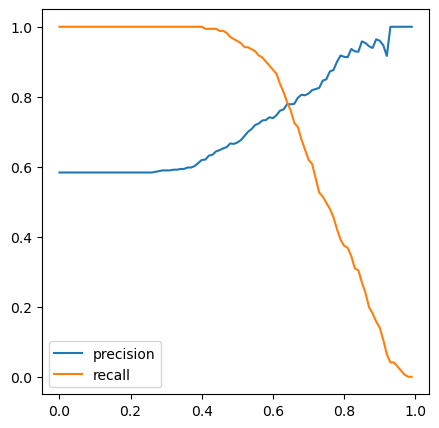

In [19]:
plt.figure(figsize=(5, 5))

plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')

plt.legend()

### Q4 F1 Score

In [21]:
f1_scores = [(t, 2*p*r/(p+r)) for t, p, r in zip(thresholds, precisions, recalls)]
max(f1_scores, key=lambda item: item[1])

(np.float64(0.5700000000000001), np.float64(0.8124999999999999))

### Q5 5-Fold CV

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(train_val_df):
    df_train_tmp = train_val_df.iloc[train_idx]
    df_val_tmp = train_val_df.iloc[val_idx]

    y_train_tmp = df_train_tmp.converted.values
    y_val_tmp = df_val_tmp.converted.values

    del df_train_tmp['converted']
    del df_val_tmp['converted']

    dv, model = train(df_train_tmp, y_train_tmp)
    y_pred_tmp = predict(df_val_tmp, dv, model)

    auc = roc_auc_score(y_val_tmp, y_pred_tmp)
    scores.append(auc)

print(np.std(scores))

0.03580711942905165


### Q6 Hyperparameter Tuning

In [23]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(train_val_df):
        df_train_tmp = train_val_df.iloc[train_idx]
        df_val_tmp = train_val_df.iloc[val_idx]

        y_train_tmp = df_train_tmp.converted.values
        y_val_tmp = df_val_tmp.converted.values

        del df_train_tmp['converted']
        del df_val_tmp['converted']

        dv, model = train(df_train_tmp, y_train_tmp, C=C)
        y_pred_tmp = predict(df_val_tmp, dv, model)

        auc = roc_auc_score(y_val_tmp, y_pred_tmp)
        scores.append(auc)

    print(f'{C=}, {np.mean(scores)=} {np.std(scores)=}')

C=1e-06, np.mean(scores)=np.float64(0.560207852870275) np.std(scores)=np.float64(0.023798316620649906)
C=0.001, np.mean(scores)=np.float64(0.8668780317675395) np.std(scores)=np.float64(0.028746230508215103)
C=1, np.mean(scores)=np.float64(0.8221089148573075) np.std(scores)=np.float64(0.03580711942905165)
